In [328]:
using RxInfer, Distributions, LinearAlgebra

In [868]:
n_samples = 100
n_arms    = 2
n_contexts  = 2
context_dim = 2
arms     = [[1.0, 2.5], [-0.5, 2.0]] # first arm is better for the second context 11 = 2; 12 = 3.0
contexts = [[-0.5, 1.0], [0.5, 1.0]] # second arm is better for the first context 21 = 2.25; 22 = 1.75
arm_choices     = []
context_choices = []
rewards         = []
for i in 1:n_samples
    push!(context_choices, rand(1:n_contexts))
    push!(arm_choices, rand(1:n_arms))
    push!(rewards, arms[arm_choices[end]]'contexts[context_choices[end]])
end

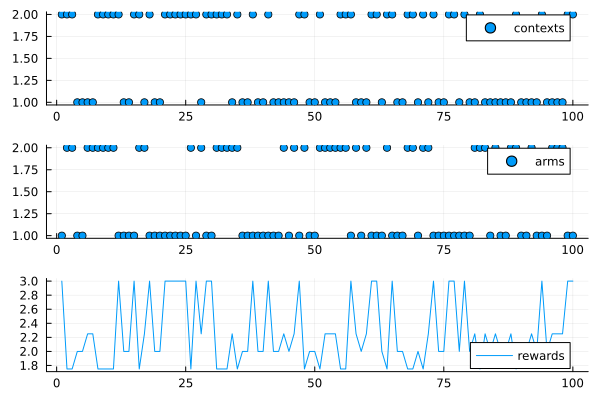

In [869]:
using Plots

p1 = scatter(context_choices, label="contexts")
p2 = scatter(arm_choices, label="arms")
p3 = plot(rewards, label="rewards")

plot(p1, p2, p3, layout=(3, 1))

In [870]:
@model function contextual_bandit(n_arms, priors, past_rewards, goal_reward, past_choices, past_contexts, current_context)
    local θ
    local γ
    # Prior for the weights over the arms
    for k in 1:n_arms
        θ[k] ~ priors[:θ][k]
        γ[k] ~ Wishart(3, diagm(ones(context_dim)))
    end
        
    for n in eachindex(past_rewards)
        arm[n] ~ NormalMixture(switch = past_choices[n], m = θ, p = γ)
        past_rewards[n] ~ Normal(μ=dot(arm[n], past_contexts[n]), γ=10.0)
    end

    s ~ priors[:s]
    z ~ Categorical(s)
    current_arm ~ NormalMixture(switch = z, m = θ, p = γ)
    goal_reward ~ Normal(μ=dot(current_arm, current_context), γ=10.0)

end

In [871]:
priors = Dict(:θ => [MvNormal([-1.0, -1.0], 1e2diagm(ones(2))), MvNormal([1.0, 1.0], 1e2diagm(ones(2)))], :s => Dirichlet(ones(n_arms)))
init = @initialization begin
    q(s) = vague(Dirichlet, n_arms)
    q(θ) = priors[:θ]
    q(γ) = Wishart(3, diagm(ones(context_dim)))
    q(current_arm) = vague(MvNormalMeanPrecision, 2)
end

results = infer(
    model = contextual_bandit(
        n_arms = n_arms, 
        priors = priors,
    ), 
    data  = (past_rewards = rewards, goal_reward=1e3, past_choices=[[[0.0, 1.0], [1.0, 0.0]][i] for i in arm_choices], past_contexts=[contexts[i] for i in context_choices], current_context=contexts[2]), 
    constraints   = MeanField(),
    initialization = init, 
    iterations  = 50, 
    free_energy = true
) 

Inference results:
  Posteriors       | available for (γ, arm, s, current_arm, z, θ)
  Free Energy:     | Real[2678.54, 1363.55, 1320.16, 1278.1, 1236.01, 1193.94, 1151.77, 1109.69, 1067.44, 1025.32  …  238.388, 238.27, 238.267, 238.205, 238.149, 238.129, 238.12, 238.183, 238.161, 238.208]


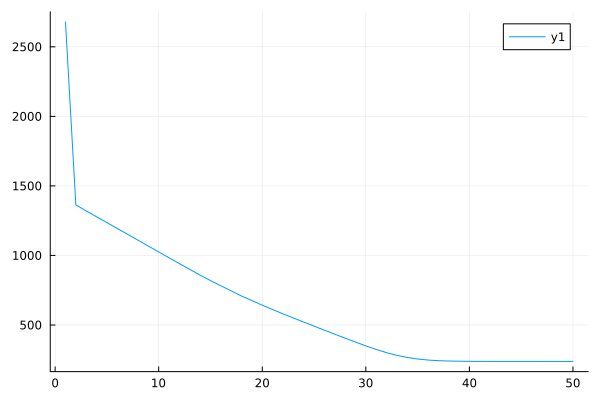

In [872]:
plot(results.free_energy)

In [873]:
mean.(results.posteriors[:θ][end])

2-element Vector{Vector{Float64}}:
 [-0.5000870182595685, 1.9998605313532445]
 [2.6949314754235516, 3.347515939433216]

In [874]:
mean.(results.posteriors[:θ][end])[2]'*contexts[2]

4.694981677144992

In [875]:
arms

2-element Vector{Vector{Float64}}:
 [1.0, 2.5]
 [-0.5, 2.0]

In [876]:
arms[2]'*contexts[2]

1.75

In [878]:
# Contextual Bandit by RxInfer
n_epochs = 500
window_length = 100
historical_choices = [[[0.0, 1.0], [1.0, 0.0]][i] for i in arm_choices]
historical_contexts_num = context_choices
historical_contexts = [contexts[i] for i in historical_contexts_num]
historical_rewards = deepcopy(rewards)
baseline_rewards = deepcopy(rewards)
posteriors = Dict(:θ => [MvNormal([-1.0, -1.0], 1e2diagm(ones(2))), MvNormal([1.0, 1.0], 1e2diagm(ones(2)))], :s => Dirichlet(ones(n_arms)))
for epoch in 1:n_epochs
    priors = Dict(:θ => posteriors[:θ], :s => posteriors[:s])
    init = @initialization begin
        q(s) = posteriors[:s]
        q(θ) = priors[:θ]
        q(γ) = Wishart(3, diagm(ones(context_dim)))
        q(current_arm) = vague(MvNormalMeanPrecision, 2)
    end

    current_context_num = rand(1:n_contexts)

    results = infer(
        model = contextual_bandit(
            n_arms = n_arms, 
            priors = priors,
        ), 
        data  = (past_rewards = historical_rewards[end-window_length+1:end], goal_reward=1e3, past_choices=historical_choices[end-window_length+1:end], past_contexts=historical_contexts[end-window_length+1:end], current_context=contexts[current_context_num]), 
        constraints   = MeanField(),
        initialization = init, 
        iterations  = 50, 
        free_energy = true
    )

    push!(historical_contexts, contexts[current_context_num]) 
    arm_to_choose = round.(rand(results.posteriors[:s][end]))
    push!(historical_choices, arm_to_choose)
    posteriors[:θ] = results.posteriors[:θ][end]
    posteriors[:s] = results.posteriors[:s][end]
    push!(historical_rewards, arms[argmax(arm_to_choose)]'contexts[current_context_num])
    push!(baseline_rewards, rand(arms)'contexts[current_context_num])
    push!(historical_contexts_num, current_context_num)
end

In [888]:
mean.(results.posteriors[:θ][end])[1]'contexts[2]

2.588823859269361

In [889]:
arms[2]'contexts[1]

2.25

In [890]:
results.posteriors[:s][end]

Dirichlet{Float64, Vector{Float64}, Float64}(alpha=[499.9999999994888, 2.000000000507044])

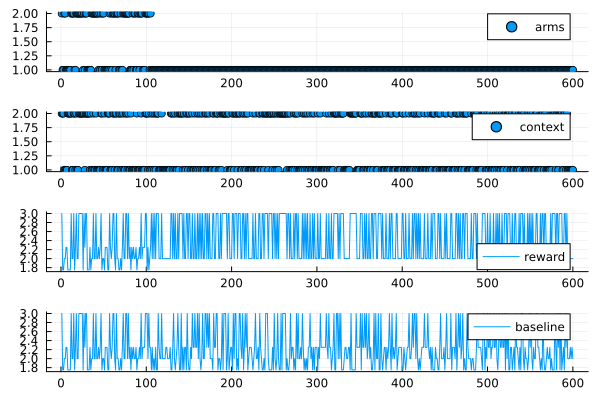

In [891]:
p1 = scatter(argmax.(historical_choices), label="arms")
p2 = scatter(historical_contexts_num, label="context")
p3 = plot(historical_rewards, label="reward")
p4 = plot(baseline_rewards, label="baseline")
plot(p1, p2, p3, p4, layout=(4, 1))

In [892]:
sum(historical_rewards)

1456.75

In [893]:
sum(baseline_rewards)

1344.25